In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import altair as alt

import scipy.cluster.hierarchy as hc

import rdatasets  as rds
from sklearn.datasets import load_iris, load_wine, fetch_olivetti_faces, load_digits

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn.metrics import rand_score, silhouette_score, adjusted_mutual_info_score, confusion_matrix, ConfusionMatrixDisplay

# Clustering

In supervised algorithms we have input, output pairs and the machine learning algorithms try to create a model that aims to create output by looking at the input only with some error. In unsupervised algorithms, we only have data and a task that we aim to accomplish using this data.

In the examples of unsupervised algorithms we have seen so far the task is to create a sensible partition of the data. This is called [clustering](https://en.wikipedia.org/wiki/Cluster_analysis). So, assume $D = \{ x^{(i)} \mid i=1,\ldots,N \}$ is our collection of data points and we want to create a partition

$$p_j\colon D\to \{ 1,\ldots, m \}$$

The only ML algorithm we have seen so far to accomplish this task is [k-means](https://en.wikipedia.org/wiki/K-means_clustering).

Today, we are going to add a two new algorithms:

1. [Hiearchical Clustering](https://en.wikipedia.org/wiki/Hierarchical_clustering)
2. [DBSCAN](https://en.wikipedia.org/wiki/DBSCAN)

First, let us recall the k-means algorithm: 

## K-Means

K-Means is a unsupervised algorithm. We have data points $D = \{ x^{(1)},\ldots,x^{(N)} \}$ and a number $k$. Here is a short description of the algorithm:

1. Start with randomly chosen points $c^{(1)},\ldots,c^{(k)}$ from $D$ and $k$ empty sets $S^{(1)},\ldots,S^{(k)}$.
2. For each point $x^{(i)}$ in $D$, find the closest centroid $c^{(j)}$ and add $x^{(i)}$ to $S^{(j)}$.
3. Find the center of each $S^{(i)}$ and call them $d^{(1)},\ldots,d^{(k)}$.
4. If each $c^{(i)}$ and $d^{(i)}$ are close enough terminate the algorithm, if not assign $c^{(i)}\leftarrow d^{(i)}$ and go to step 2.


## Hiearchical clustering

Here is the setup: Hierarchical clustering algorithm is an unsupervised algorithm. The algorithm gradually merge points into clusters. 

1. Place each point in a cluster that contain only themselves.
2. Merge two clusters with the smallest distance.
3. Repeat Step 2 until all clusters are merged.

The algorithm works by placing a ball $B_\epsilon(x)$ of radius $\epsilon$ on each $x\in D$. We merge two points $x_1$ and $x_2$ at a specific $\epsilon$ if $B_\epsilon(x_1)$ and $B_\epsilon(x_2)$ intersect. While this is straightforward for individual pairs of points, one has to decide how clusters of points merge when $\epsilon$ is large enough. This is called the *linkage* method. 

Let us use $ d_{(ij)k} $ to denote the distance between the clusters $ C_{k} $ and $ C_{ij} = C_i \cup C_j $ which is merged in a single cluster.  One calculates the distance 
\\[ d_{(ij)k} = \alpha_{ijk} d_{ik} +\alpha_{jik} d_{jk}+ \beta_{ijk} d_{ij} + \gamma|d_{ik}-d_{jk}| \\] 
for parameters $\alpha_{ijk}$, $\beta_{ijk}$ and $\gamma$ to be determined.  

The most frequently used linkage methods and the parameters for commonly used methods of calculating distances between clusters are as follows:

<table>
    <tr><th>Linkage</th>
        <th>$\alpha_{ijk}$</th>
        <th>$\beta_{ijk}$</th>
        <th>$\gamma$</th></tr>
    <tr><td>Single</td>
        <td>$\frac{1}{2}$</td>
        <td>0</td>
        <td>$-\frac{1}{2}$</td></tr>
    <tr><td>Complete</td>
        <td>$\frac{1}{2}$</td>
        <td>0</td>
        <td>$\frac{1}{2}$</td></tr>
    <tr><td>Average</td>
        <td>$\frac{n_i}{n_i+n_j}$</td>
        <td>0</td>
        <td>0</td></tr>
    <tr><td>Ward</td>
        <td>$\frac{n_i+n_k}{n_i+n_j+n_k}$</td>
        <td>$\frac{-n_k}{n_i+n_j+n_k}$</td>
        <td>0</td></tr>
</table>

## Examples
### Iris

In [4]:
raw = load_iris()
X = raw['data']
y = raw['target']

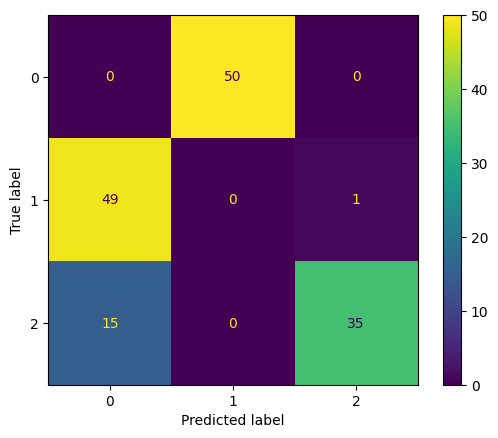

In [6]:
model = AgglomerativeClustering(n_clusters=3)
model.fit(X)
y_pred = model.fit_predict(X)
ConfusionMatrixDisplay.from_predictions(y,y_pred)

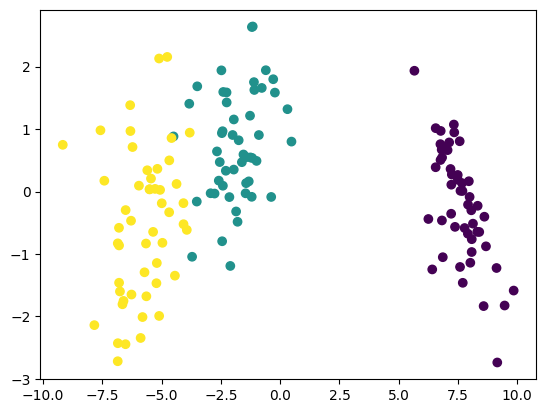

In [7]:
projector = LinearDiscriminantAnalysis(n_components=2)
Xp = projector.fit_transform(X,y)
plt.scatter(Xp[:,0],Xp[:,1],c=y)

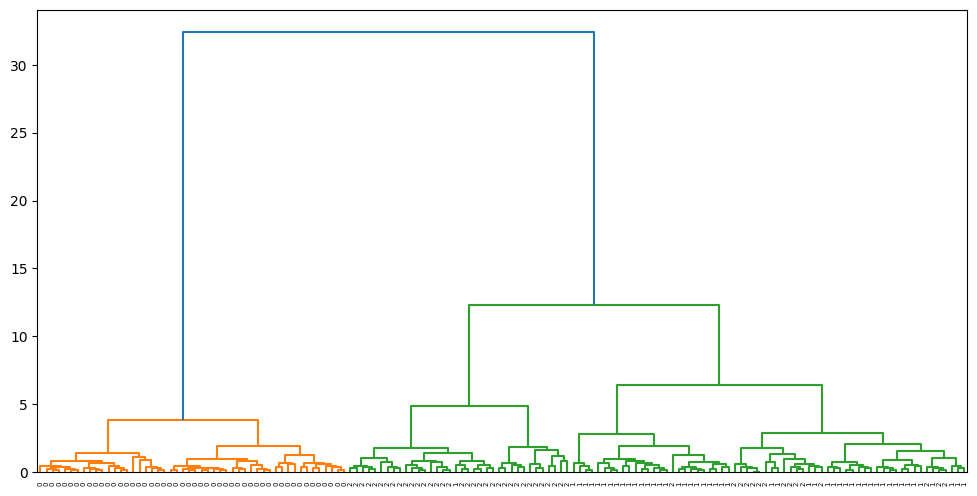

In [9]:
plt.figure(figsize=(12,6))
den = hc.dendrogram(hc.linkage(X, method='ward'), orientation='top',labels=y)

### USA Arrests

In [10]:
arrests = rds.data('USArrests')
arrests

,rownames,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6
5,Colorado,7.9,204,78,38.7
6,Connecticut,3.3,110,77,11.1
7,Delaware,5.9,238,72,15.8
8,Florida,15.4,335,80,31.9
9,Georgia,17.4,211,60,25.8


In [11]:
X = arrests[['Murder','Assault','Rape']]
y = arrests['rownames']

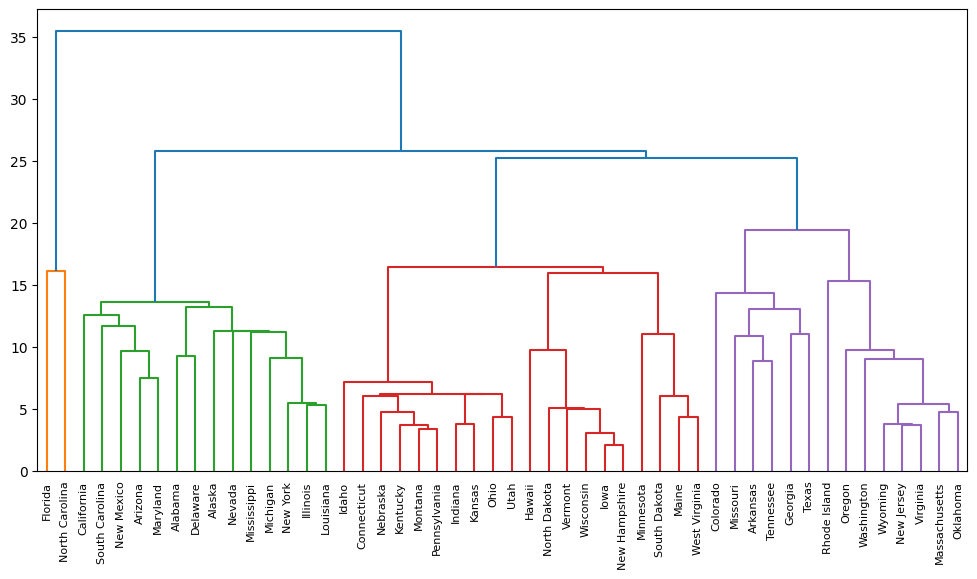

In [12]:
plt.figure(figsize=(12,6))
den = hc.dendrogram(hc.linkage(X.to_numpy(), method='single'), orientation='top',labels=y.to_numpy())

### Turkish Crime Statistics



In [15]:
raw = pd.read_excel('../data/turkiye_suc_istatistikleri_2022.xls')
data = raw[raw['Gender'].notna()]
del data['Gender'], data['Total']
data = data.replace('-',0)
data.iloc[:,1:] = data.iloc[:,1:].astype(np.int32)
data

/tmp/ipykernel_124621/2776838312.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.replace('-',0)


,City,Homicide,Assault,Sexual crimes,Kidnapping,Defamation,Theft,Robbery,Swindling,Drugs with intent to sell,...,Forestry crimes,Crimes with deadly weapons,Financial crimes,Military crimes,Threat,Damage to property,Resistance to arrest,Domestic dispute,Other Crimes,Unknown
0,İstanbul,1026,5055,820,811,520,6306,2023,1846,1954,...,43,1655,1230,499,916,292,563,612,6569,61
1,NaN,26,123,6,16,32,487,62,108,131,...,3,9,53,0,25,23,25,25,382,3
3,Tekirdağ,71,453,76,60,46,509,90,58,63,...,2,65,154,239,97,31,46,136,367,2
4,NaN,3,7,0,2,1,23,6,0,10,...,0,0,7,0,2,2,2,1,19,0
6,Edirne,39,260,39,28,28,226,41,38,58,...,2,32,65,200,49,11,20,30,596,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,Şırnak,11,59,7,19,5,98,10,16,16,...,0,25,4,45,18,5,15,8,214,1
238,NaN,0,1,0,0,1,3,0,1,0,...,0,0,0,0,1,0,0,0,11,0
240,Siirt,12,95,10,9,6,106,18,3,14,...,1,26,1,16,19,11,13,22,114,0
241,NaN,1,2,0,5,1,3,0,0,0,...,0,0,0,0,0,0,0,0,6,0


In [16]:
N = int((data.shape[0]-1)/2)
tmp = []
for i in range(N):
    tmp.append(data.iloc[2*i,1:]+data.iloc[2*i+1,1:])
    tmp[i] = tmp[i]/sum(tmp[i])
               
X = pd.DataFrame(tmp)
y = [data.iloc[2*i,0] for i in range(N)]

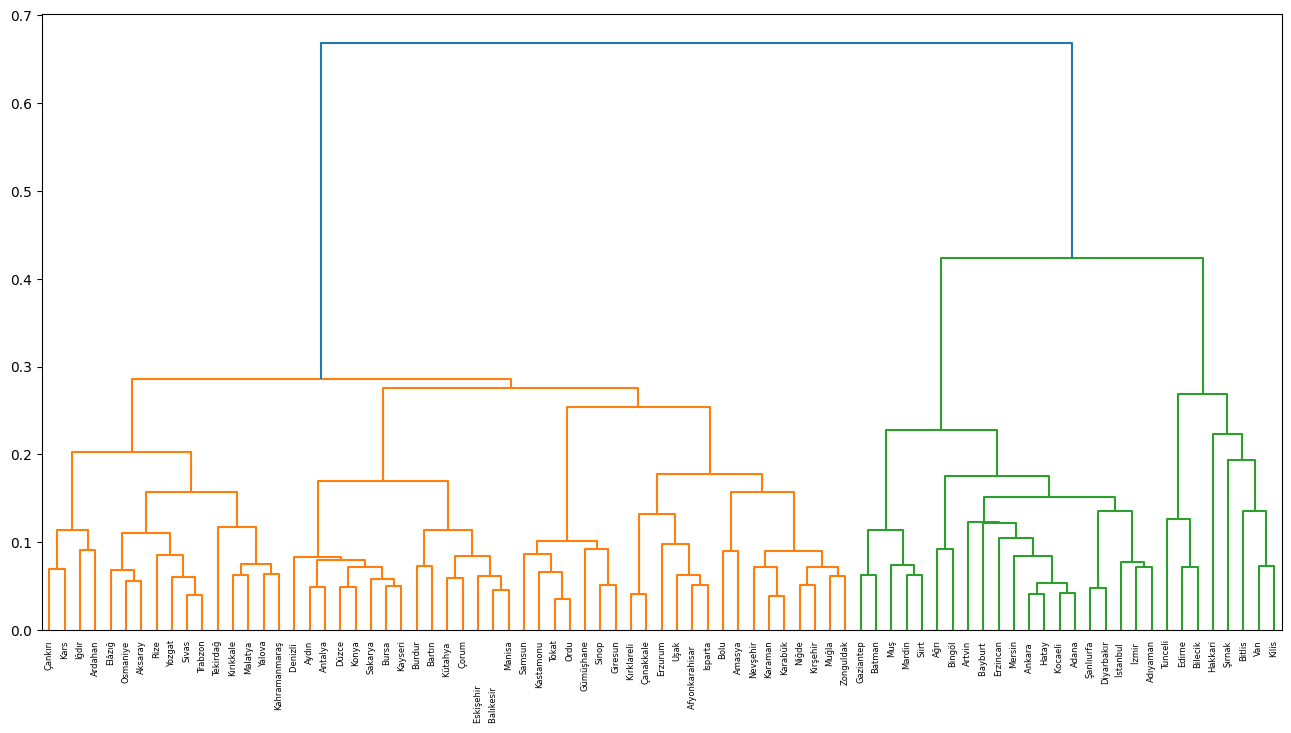

In [17]:
plt.figure(figsize=(16,8))
den = hc.dendrogram(hc.linkage(X, method='ward'), orientation='top',labels=y)

In [18]:
def interactiveDraw(xs,ys,labels,cs,size=(800,400)):
    data = pd.DataFrame({'x': xs, 'y': ys, 'label': labels, 'color': cs})
    return alt.Chart(data).mark_circle(size=100).encode(
                x='x',
                y='y',
                color=alt.Color('color').scale(scheme="dark2"),
                tooltip=['label']
            ).properties(width=size[0],
                         height=size[1]
                        ).interactive()

In [19]:
model = AgglomerativeClustering(n_clusters=3)
colors = model.fit_predict(X)
projector = LinearDiscriminantAnalysis(n_components=2)
turkey_points = projector.fit_transform(X,colors)
interactiveDraw(turkey_points[:,0],turkey_points[:,1],data.dropna().iloc[:81,0],colors,(800,500))

alt.Chart(...)

## DBSCAN

DB-Scan is a unsupervised algorithm. So, we only have data points $x^{(1)},\ldots,x^{(N)}$ and no output labels. The parameters are

1. A real number $\epsilon>0$, and 
2. A natural number $N$,

The key concepts for this algorithm are

- **Core points**: A point $x\in D$ is called a *core point* if $B_\epsilon(x)$ the ball with radius $\epsilon$ centered at $x$ contains $N$ points from $D$
    
- **Density connected points**: A pair of points $x$ and $y$ are called *density connected* if there is a core point $w$ such that $x,y\in B_\epsilon(w)$.

- **Density reachable points**: A point $x\in D$ is called a *directly density reachable* if $x$ is lies inside $B_\epsilon(u)$ the disk of radius $\epsilon$ centered at a core point $u$.

- **Indirectly density reachable points**: We call a point *indirectly density reachable* if there is a link of density connected points $x^{(1)},\ldots,x^{(p)}$ i.e. $d(x^{(i)},x^{(i+1)})<\epsilon$ for $i=1,\ldots,p-1$ and $d(x^{(p)},x)<\epsilon$.

- **Border points**: A point $x$ is called a *border point* if it is a density reachable point but $B_\epsilon(x)$ has less than $N$ points from $D$.

- **Outlier points**: A point $x$ is called an outlier if $B_\epsilon(x)$ contains less than $N$ points and $x$ is not a density reachable point.


### The Algorithm
    
We put point a collection of points $x^{(1)},\ldots,x^{(\ell)}$ in the same cluster if they are density reachable from each other.

## An Example

For this example, we are going to use the [wine dataset]() 

In [20]:
wine = load_wine()
wine_X = wine['data']
wine_y = wine['target']
pd.DataFrame(wine_X)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0


In [21]:
projector = LinearDiscriminantAnalysis(n_components=2)
wine_points = projector.fit_transform(wine_X,wine_y)
interactiveDraw(wine_points[:,0],wine_points[:,1],wine_y,wine_y)

alt.Chart(...)

In [22]:
model = DBSCAN(eps=1.0,min_samples=3)
wine_y_pred = model.fit_predict(wine_points)
wine_y_pred

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,
       -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
        1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2])

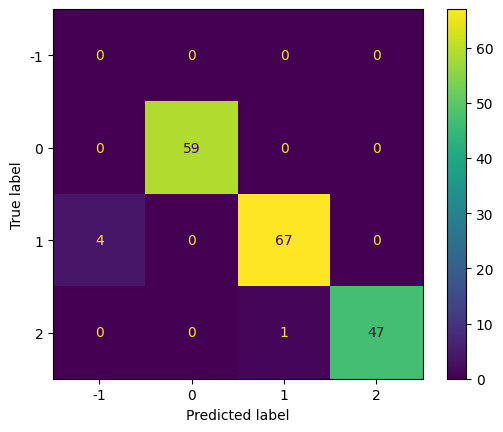

In [23]:
ConfusionMatrixDisplay.from_predictions(wine_y,wine_y_pred)

## Another Example

For this example, we are going to use the Olivetti faces dataset.

In [24]:
faces = fetch_olivetti_faces()
faces_X = faces['data']
faces_y = faces['target']

In [25]:
projector = LinearDiscriminantAnalysis(n_components=2)
faces_points = projector.fit_transform(faces_X,faces_y)
interactiveDraw(faces_X[:,0],faces_X[:,1],faces_y,faces_y)

alt.Chart(...)

In [26]:
def displayCM(y_test,y_pred,size=(12,12)):
    disp = ConfusionMatrixDisplay.from_predictions(y_test,y_pred, display_labels=None)
    fig = disp.ax_.get_figure() 
    fig.set_figwidth(size[0])
    fig.set_figheight(size[1])  

<Figure size 1000x1000 with 0 Axes>

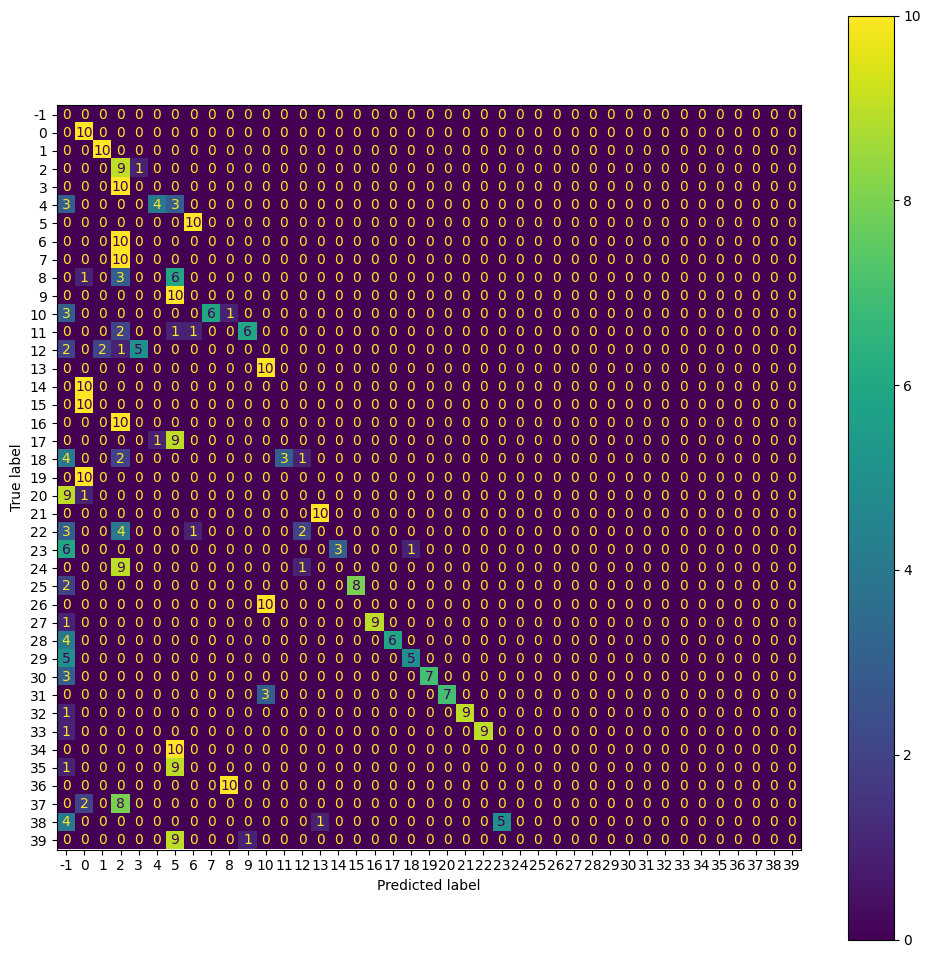

In [27]:
model = DBSCAN(eps=0.9,min_samples=3)
faces_y_pred = model.fit_predict(faces_points)
plt.figure(figsize=(10, 10))
displayCM(faces_y, faces_y_pred)

In [28]:
interactiveDraw(faces_X[:,0],faces_X[:,1],faces_y,faces_y_pred)

alt.Chart(...)

## An Important Question

### How can we check the quality of a clustering scheme?

Since (technically) we don't have a collection of outputs that we need to match with the input, how can we check the quality of a clustering scheme becomes an important problem we must solve. For this purpose there are several metrics we can use. The most commonly used ones are

1. [rand score](https://en.wikipedia.org/wiki/Rand_index)
2. [silhoutte score](https://en.wikipedia.org/wiki/Silhouette_(clustering))
3. [mutual information](https://en.wikipedia.org/wiki/Adjusted_mutual_information)

### Rand score

Let us assume our dataset $D$ contains $N$ points $x^{(1)},\ldots,x^{(N)}$. Let us assume we have two partitions $P = \{ p_1 ,\ldots, p_n \}$ and $Q = \{ q_1,\ldots,q_m \}$. Let us define

1. $a$: the number of pairs of elements in $D$ that are in the same partition subset in $P$ and partition subset in $Q$.
2. $b$: the number of pairs of elements in $D$ that are in different subsets in $P$ and in $Q$.
3. $c$: the number of pairs of elements in $D$ that are in the same subset in $P$ but in different subsets in $Q$.
4. $d$  the number of pairs of elements in $D$ that are in different subsets in $P$ but in the same subset in $Q$.

Consider the following simple example

$D = \{ 1,2,3,4 \}$, $P = \{ \{1,2\}, \{3,4\} \}$ and $Q = \{\{1,2\}, \{3\} ,\{4\}\}$.

Let us enumerate all pairs:

1. (1,2): They are the same partition in $P$ and $Q$.
2. (1,3): They are in different partitions in both $P$ and $Q$.
3. (1,4): They are in different partitions in both $P$ and $Q$.
4. (2,3): They are in different partitions in both $P$ and $Q$.
5. (2,4): They are in different partitions in both $P$ and $Q$.
6. (3,4): They are in the same partition in $P$ but different partition in $Q$.

Thus we get $a = 1$, $b = 4$, $c=1$, $d=0$. The rand index is

$$ \frac{a+b}{\binom{N}{2}} = \frac{5}{6} $$

The closer the index to 1 the better the alignment between $P$ and $Q$.

In [29]:
rand_score(wine_y,wine_y_pred)

np.float64(0.9757506506697137)

In [30]:
rand_score(faces_y, faces_y_pred)

np.float64(0.9145989974937343)

### Silhouette score

Assume we have a partition $P = \{ p_1,\ldots, p_n \}$ for a collection of points $D = x^{(1)},\ldots,x^{(N)}$. For any point $x^{(i)}\in D$ and $x^{(i)}\in p_j$ define

$$ a_i = \frac{1}{|p_j|-1}\sum_{x\in p_j} d(x,x^{(i)}) $$
and
$$ b_{i,\ell} = \frac{1}{|p_\ell|} \sum_{x\in p_\ell} d(x,x^{(i)}) \quad\text{ and }\quad b_i = \min_{\ell\neq j} b_{i,\ell} $$

The silhoutte score of a point $s_i$ is defined as 0 if the point is its own partition set, and
$$ s_i = \frac{b_i-a_i}{\max(a_i,b_i)} $$
and the silhouette score of a partition is
$$ SC(P) = \max_i s_i $$

For the example $D = \{ 1,2,3,4\}$ with $P = \{ \{1,2\}, \{3,4\} \}$ we have
$$ a_1 = 1, a_2 = 1, a_3 = 1, a_4 = 1$$
$$ b_1 = 2.5, b_2 = 1.5, b_3 = 1.5, b_4 = 2.5 $$
$$ s_1 = 0.6, s_2 = 0.33, s_3 = 0.33, s_4 = 0.6 $$
and $SC(P)=0.6$.

We want $s_i \approx 1$ for every point.

In [31]:
silhouette_score(wine_points,wine_y),\
silhouette_score(wine_points,wine_y_pred)

(np.float64(0.663169998607709), np.float64(0.5670944631855265))

In [32]:
silhouette_score(faces_points,faces_y),\
silhouette_score(faces_points,faces_y_pred)

(np.float32(0.24200173), np.float32(0.24398525))

### Mutual Information

Every probability distribution carries an inherent information measured by [entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory)). Given a partition $Q = \{ q_1,\ldots,q_n\}$ of a dataset $D = \{ x^{(1)},\ldots, x^{(N)} \}$ the probability that a point lies in partition subset $q_j$ is 
$P_j = \frac{|q_j|}{N}$. The entropy (information content) of the partition then is calculated as

$$ H(Q) = \sum_j -P_J \log(P_J) $$

Let us assume we have another partition $U = \{ U_1, \ldots, U_m \}$ and we calculate its information content as

$$ H(U) = \sum_j -P'_j \log(P'_j) \quad\text{ where }\quad P'_j = \frac{|U_j|}{N} $$

When we compare these partitions we get the mutual information as

$$ H(U|V) = \sum_i\sum_j \frac{|P_i\cap U_j|}{N}\log\left(\frac{N\cdot |P_i\cap U_j|}{|P_i||U_j|}\right) $$

Let us re-consider the example $D = \{1,2,3,4\}$ with $P = \{\{1,2\},\{3,4\}\}$ and $Q = \{\{1,2\},\{3\},\{4\}\}$.

$H(P) = -\frac{2}{4}\log_2(2/4) - \frac{2}{4}\log_2(2/4) = 1$

$H(Q) = -\frac{2}{4}\log_2(2/4) - \frac{1}{4}\log_2(1/4) - \frac{1}{4}\log_2(1/4) = 3/2$

$ p_1 \cap q_1 = \{1,2\} $

$ p_1 \cap q_2 = \emptyset = p_1\cap q_3 = p_2 \cap q_1 $

$ p_2 \cap q_2 = \{3\}$ 

$ p_2 \cap q_3 = \{4\}$

$ H(P|Q) = \frac{2}{4}\log_2(2) + \frac{1}{4} \log_2(2) + \frac{1}{4}\log_2(2) = 1$

In [33]:
adjusted_mutual_info_score(wine_y,wine_y_pred)

np.float64(0.9355486013340094)

In [34]:
adjusted_mutual_info_score(faces_y,faces_y_pred)

np.float64(0.6127305952708724)

## A final example


In [35]:
raw = load_digits()
digits_X = raw['data']
digits_y = raw['target']
digits_y

array([0, 1, 2, ..., 8, 9, 8], shape=(1797,))

In [36]:
projector = TSNE(n_components=2)
digits_points = projector.fit_transform(digits_X,digits_y)

In [37]:
interactiveDraw(digits_points[:,0],digits_points[:,1],digits_y,digits_y,size=(800,500))

alt.Chart(...)

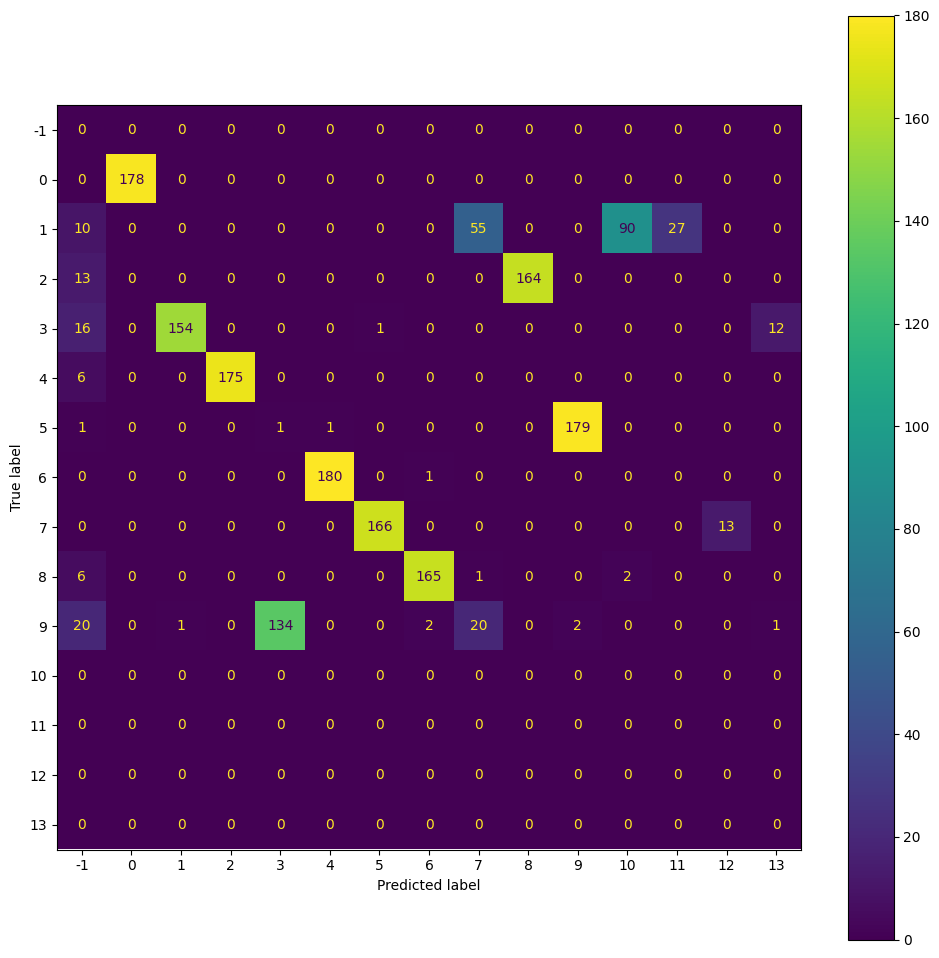

In [38]:
model = DBSCAN(eps=2.9,min_samples=13)
digits_y_pred = model.fit_predict(digits_points)
displayCM(digits_y,digits_y_pred)

In [39]:
interactiveDraw(digits_points[:,0],digits_points[:,1],digits_y,digits_y_pred,size=(800,800))

alt.Chart(...)

In [40]:
def experiment(X_test,y_test,y_pred):
    return {'rand': rand_score(y_test,y_pred),
            'mutual info': adjusted_mutual_info_score(y_test,y_pred),
            'silhouette score labels': silhouette_score(X_test,y_test),
            'silhouette score pred': silhouette_score(X_test,y_pred)}

In [41]:
experiment(digits_points,digits_y,digits_y_pred)

{'rand': np.float64(0.9785574323947485),
 'mutual info': np.float64(0.8952925719950023),
 'silhouette score labels': np.float32(0.5543348),
 'silhouette score pred': np.float32(0.5327127)}

{'rand': 1.0,
 'mutual info': np.float64(0.9999999999999998),
 'silhouette score labels': np.float64(0.663169998607709),
 'silhouette score pred': np.float64(0.663169998607709)}

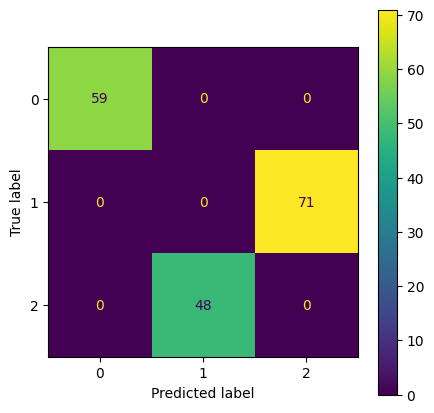

In [42]:
model = KMeans(n_clusters=3)
wine_y_pred = model.fit_predict(wine_points)
displayCM(wine_y,wine_y_pred,size=(5,5))
experiment(wine_points,wine_y,wine_y_pred)

{'rand': 1.0,
 'mutual info': np.float64(0.9999999999999998),
 'silhouette score labels': np.float64(0.663169998607709),
 'silhouette score pred': np.float64(0.663169998607709)}

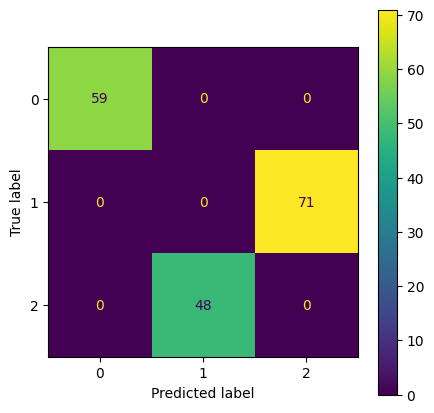

In [43]:
model = AgglomerativeClustering(n_clusters=3)
wine_pred_y = model.fit_predict(wine_X)
displayCM(wine_y,wine_y_pred,size=(5,5))
experiment(wine_points,wine_y,wine_y_pred)

{'rand': np.float64(0.9561353393004507),
 'mutual info': np.float64(0.8856663089486128),
 'silhouette score labels': np.float64(0.663169998607709),
 'silhouette score pred': np.float64(0.5959842887574329)}

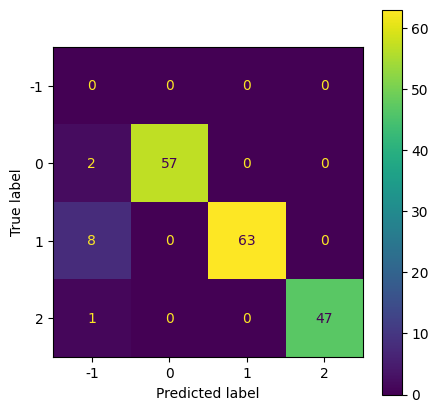

In [44]:
model = DBSCAN(eps=1.0,min_samples=10)
wine_y_pred = model.fit_predict(wine_points)
displayCM(wine_y,wine_y_pred,size=(5,5))
experiment(wine_points,wine_y,wine_y_pred)

In [45]:
model = KMeans(n_clusters=40)
faces_y_pred = model.fit_predict(faces_X)
#displayCM(faces_y,faces_y_pred)
experiment(faces_points,faces_y,faces_y_pred)

{'rand': np.float64(0.969498746867168),
 'mutual info': np.float64(0.609480647046121),
 'silhouette score labels': np.float32(0.24200173),
 'silhouette score pred': np.float32(-0.17812066)}

In [46]:
model = AgglomerativeClustering(n_clusters=40)
faces_y_pred = model.fit_predict(faces_points)
#displayCM(faces_y,faces_y_pred)
experiment(faces_X,faces_y,faces_y_pred)

{'rand': np.float64(0.9779197994987469),
 'mutual info': np.float64(0.698978346167866),
 'silhouette score labels': np.float32(0.10557363),
 'silhouette score pred': np.float32(-0.023453873)}

{'rand': np.float64(0.9145989974937343),
 'mutual info': np.float64(0.6127305952708724),
 'silhouette score labels': np.float32(0.10557363),
 'silhouette score pred': np.float32(-0.049386825)}

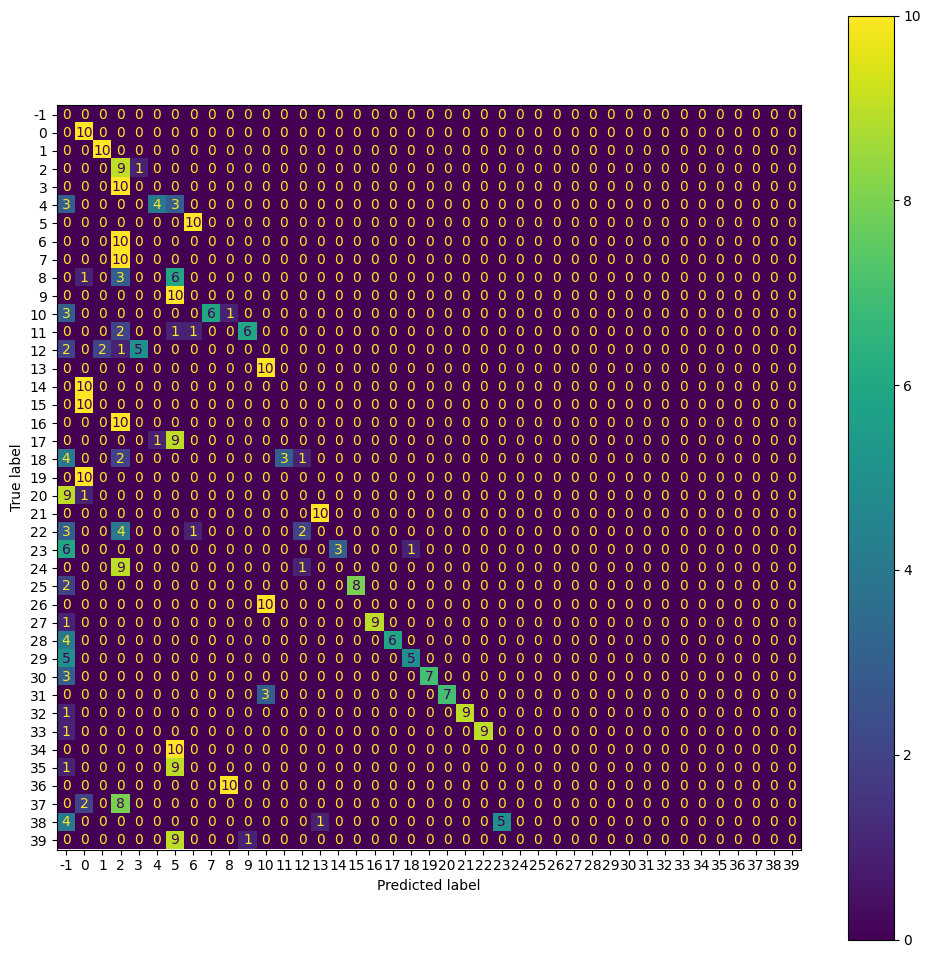

In [47]:
model = DBSCAN(eps=0.9,min_samples=3)
faces_y_pred = model.fit_predict(faces_points)
displayCM(faces_y,faces_y_pred)
experiment(faces_X,faces_y,faces_y_pred)